# FINAL PROJECT
#### Prepared by: Hassan Aluraibi
#### For: Dr. Brisbin
#### Title: Time series and neural network analysis on sensor data

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
import scipy as sp
import glob
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics import tsaplots

### PARQUET AND CSV FUNCTIONS
This dataset was made up of 14 CSVs, split by day.
To optimize, I combined all the CSVs into 1 dataframe, and then wrote into a CSV file

In [2]:
def createParquetFile():
    x = 0
    file_list = []
    for file in os.listdir():
        if file.endswith('.csv'):
            df = pd.read_csv(file,sep=",")
            df['filename'] = file
            df['date'] = x
            file_list.append(df)
            x += 1
    all_days = pd.concat(file_list, ignore_index=True)
    all_days.to_parquet("all.parquet")

def readInDataFrame(fileName):
    fullDataSet = pd.read_parquet(fileName)
    return fullDataSet

### CONSOLIDATE INTO 1 DATASET AND READ IN
I read in the parquet file, and converted to a dataframe.

In [3]:
#createParquetFile()
fileToReadIn = "all.parquet"
fullDataFrame = readInDataFrame(fileToReadIn)

### CHECK FOR MISSINGNESS AND COMPLETENESS
Check for null values in data frame, print out message if no nulls

In [4]:
result = fullDataFrame[fullDataFrame.isnull().any(axis=1)]
if (result.empty == True):
    print("Dataset Has 0 NAs")

Dataset Has 0 NAs


### SUB-SAMPLE, SORT & SET SEED
Subsample dataframe to conduct initial analysis, setting a random seed

In [5]:
subsetDataFrame = fullDataFrame.sample(50000, random_state= 1)
subsetDataFrame = subsetDataFrame.sort_values(["date","Time (s)"], ascending = (True,True))

### SUMMARY STATS
Conducted a series of analyses to evaluate and better understand the dataset.

In [6]:
subsetDataFrame.describe()

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),...,R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm),date
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,45333.081023,9.927506,46.073960,25.722952,239.947002,0.353882,16.389105,18.402828,22.957224,21.413355,...,29.505631,32.756279,27.970506,23.676607,26.124744,28.304845,26.263093,23.263892,29.160597,6.020360
std,26281.925039,6.444543,12.419229,0.929620,2.031646,0.287703,23.932194,27.587280,29.126032,17.726427,...,27.674367,28.147468,20.546413,18.750705,20.893179,21.119495,19.319207,18.037217,22.564497,3.732059
min,0.000000,0.000000,16.350000,21.860000,0.000000,0.198000,0.032900,0.056900,0.056900,0.040400,...,0.051900,0.053200,0.033200,0.029600,0.037200,0.030900,0.032700,0.033700,0.031400,0.000000
25%,22661.372000,4.440000,36.940000,25.180000,239.896300,0.200000,0.416350,0.495300,0.607000,2.082250,...,1.623125,1.993200,12.034300,8.253425,7.940975,10.879300,10.052550,7.990450,10.115500,3.000000
50%,45205.651000,8.890000,47.150000,26.020000,239.972350,0.200000,1.997900,1.532000,4.692500,21.715600,...,24.417500,33.533300,27.643100,21.872300,23.859400,27.739600,26.310200,21.995900,27.320600,6.000000
75%,68069.991750,15.560000,55.740100,26.380000,240.043600,0.207000,28.691100,31.897000,46.560400,34.592300,...,50.836900,54.023100,42.367900,36.454300,41.030400,43.218900,40.463300,36.092100,45.771500,9.000000
max,90907.874000,20.000000,83.810000,27.420000,275.230500,0.901900,122.884600,119.585100,118.864700,83.683900,...,115.358500,130.745300,96.841400,87.723400,97.812400,93.940100,91.134600,81.705100,93.423500,12.000000


A quick look at distributions of all sensors/variables.
* Our target response variable (CO PPM) is uniformly distributed
* If sensors are organized ordinally, then it appears that ordinal relationships between sensors influences their distributions
* This means it appears that sensor 1 is closer in readings to sensor 2, than sensor 4.
* I will not be using voltage, temperature or humdiity, but their distributions are shown for reference

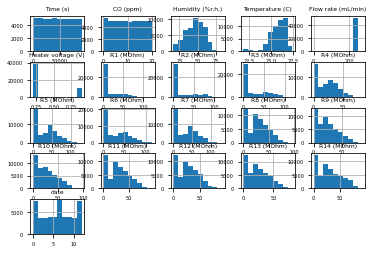

In [7]:
plt.rcParams.update({'font.size':5})
subsetDataFrame.hist(layout=(5,5))
plt.show()

Using boxplots grouped by day, I get visual assurance that the CO (ppm) has a similar distribution across all days from the dataset

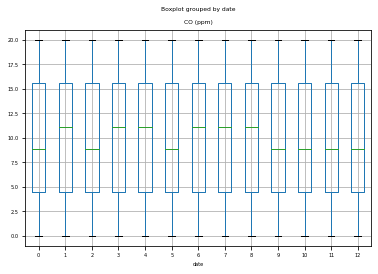

In [8]:
subsetDataFrame.boxplot(column = 'CO (ppm)', by = 'date')
plt.show()

### HEATMAP
A heatmap reassures me that dropping humidity, temperature, voltage and flow rate is beneficial,
as they have no observed correlation with the response.
The sensors exhibit a significant amount of correlation, which makes sense as they are likely stage next to one another,
measuring similar values of CO (ppm).
It appears that some of the sensors, are more highly correlated with CO (ppm) than others.

<AxesSubplot:>

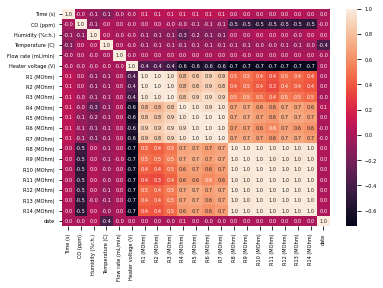

In [9]:
correlationMatrix = subsetDataFrame.corr()
sb.heatmap(correlationMatrix, annot=True, fmt = '.1f', annot_kws={'size':5})

### REGRESSION TEST
I conducted a preliminary analysis using ols to evaluate a basic model fit.
The r-squared performs poorly (0.478), hopefully a lagging analysis will improve this result.
All predictors are significant

In [10]:
modelLM = smf.ols(formula= "Q('CO (ppm)') ~ Q('Time (s)') + Q('R1 (MOhm)') + Q('R2 (MOhm)') + Q('R3 (MOhm)') + Q('R4 (MOhm)') + Q('R5 (MOhm)') + Q('R6 (MOhm)') + Q('R7 (MOhm)') + Q('R8 (MOhm)') + Q('R9 (MOhm)') + Q('R10 (MOhm)') + Q('R11 (MOhm)') + Q('R12 (MOhm)') + Q('R14 (MOhm)') + date", data=subsetDataFrame)
modelResults = modelLM.fit()
print(modelResults.summary())

                            OLS Regression Results                            
Dep. Variable:          Q('CO (ppm)')   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     3056.
Date:                Wed, 05 May 2021   Prob (F-statistic):               0.00
Time:                        21:08:30   Log-Likelihood:            -1.4784e+05
No. Observations:               50000   AIC:                         2.957e+05
Df Residuals:                   49984   BIC:                         2.958e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          12.5569      0.062    2

### QQPLOT
A QQ plot indicates that the line fits reasonably well, although it does appear to skew at its tails.

c:\users\hassa\appdata\local\programs\python\python38\projects\ds740final\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


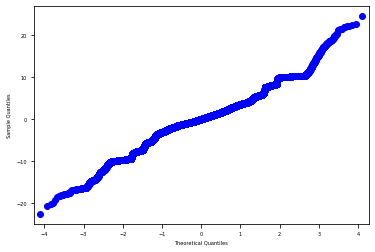

In [11]:
predictorDF = subsetDataFrame.drop(['CO (ppm)','filename'], axis=1)
responseDF = subsetDataFrame['CO (ppm)']
modelFit = sm.OLS(responseDF.astype(float),predictorDF.astype(float)).fit()
res = modelFit.resid
fig = sm.qqplot(res)
plt.show()

predictorDF_Train, predictorDF_Test, responseDF_Train, responseDF_Test = train_test_split(predictorDF, responseDF, test_size=0.2, random_state=12)
predictorDF_Train, predictorDF_Val, responseDF_Train, responseDF_Val = train_test_split(predictorDF_Train, responseDF_Train, test_size=0.25, random_state=12) # 0.25 x 0.8 = 0.2

### TIME SERIES
A pair plot of all predictors across time shows no significant trends. The data appears scattered over time
The autocorrelation plot indicates a significant amount of autocorrelation
By introducing a lag of 10 into our autoregressive model, the R^2 result of this OLS model is 0.874. Significantly
better than the no auto-regressed model.

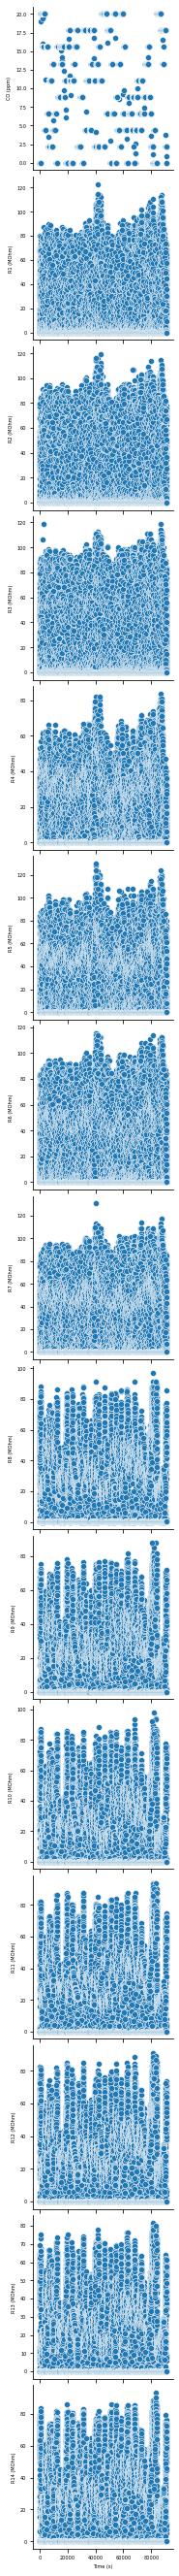

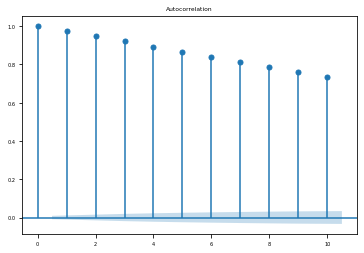

                                GLSAR Regression Results                               
Dep. Variable:               CO (ppm)   R-squared (uncentered):                   0.875
Model:                          GLSAR   Adj. R-squared (uncentered):              0.875
Method:                 Least Squares   F-statistic:                          1.049e+04
Date:                Wed, 05 May 2021   Prob (F-statistic):                        0.00
Time:                        21:08:38   Log-Likelihood:                         -85510.
No. Observations:               29996   AIC:                                  1.711e+05
Df Residuals:                   29976   BIC:                                  1.712e+05
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [12]:
pp = sb.pairplot(data = subsetDataFrame, y_vars=['CO (ppm)', 'R1 (MOhm)', 'R2 (MOhm)', 'R3 (MOhm)','R4 (MOhm)', 'R5 (MOhm)', 'R6 (MOhm)', 'R7 (MOhm)', 'R8 (MOhm)','R9 (MOhm)', 'R10 (MOhm)', 'R11 (MOhm)', 'R12 (MOhm)', 'R13 (MOhm)','R14 (MOhm)'], x_vars=['Time (s)'])
plt.show()
fig = tsaplots.plot_acf(responseDF, lags = 10)
plt.show()
glsAR_model = sm.GLSAR(responseDF_Train, predictorDF_Train, 4)
glsAR_results = glsAR_model.iterative_fit(maxiter=1)
print(glsAR_results.summary())
y_pred = glsAR_results.predict(predictorDF_Test)
MSE = ((responseDF_Test - y_pred)**2).sum()
MSE = MSE / len(predictorDF_Test)

print(f"Mean Squared Error Rate: \n Value: {(MSE):>0.6f}")

### NEURAL NETWORK

##### I referenced two examples from the internet.
##### https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
##### https://www.youtube.com/watch?v=YAJ5XBwlN4o

I trained a neural network using pytorch with the following conditions
* n_features = 15 (1 for each sensor, and date)
* setting a seed and looping to identify best learning rate
* scaling the predictors
* using SGD which uses a mini batch of points during each Epoch, easier to compute
* Converting my dataframes to tensors so that they can be computed
* I used a linear neural network (regression)

In [13]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU
    return device

def df_to_tensor1(df):
    device = get_device()
    return torch.from_numpy(df).float().to(device)

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

scaler = StandardScaler()

predictorDF = scaler.fit_transform(predictorDF)

In [14]:
responseDF = preprocessing.normalize([responseDF])
responseDF = pd.DataFrame(responseDF)
responseDF = responseDF.transpose()

In [15]:
predictorDF_Train, predictorDF_Test, responseDF_Train, responseDF_Test = train_test_split(predictorDF, responseDF, test_size=0.2, random_state=12)
predictorDF_Train, predictorDF_Val, responseDF_Train, responseDF_Val = train_test_split(predictorDF_Train, responseDF_Train, test_size=0.25, random_state=12)

xPredictTrain = df_to_tensor1(predictorDF_Train)
yResponseTrain = df_to_tensor(responseDF_Train)
xPredictTest = predictorDF_Test
xPredictTest = df_to_tensor1(xPredictTest)
yResponseTest = responseDF_Test

n_samples, n_features = xPredictTrain.shape
input_size = n_features
out_size = 1
model = nn.Linear(input_size,out_size)

learning_rate = 0.01
criterion = nn.MSELoss()
learningRateList = [0.001, 0.05, 0.1]
num_epochs = 100
finalErrorRate = []





torch.manual_seed(1)

x = df_to_tensor1(predictorDF)
y = df_to_tensor(responseDF)

n_samples, n_features = x.shape
input_size = n_features
out_size = 1
model = nn.Linear(input_size,out_size)
criterion = nn.MSELoss()
learningRateList = [0.001, 0.01, 0.05]
finalErrorRate = []

num_epochs = 100

for learningRate in learningRateList:
    print('------------------------------------')
    for epoch in range(num_epochs):
        optimizer = torch.optim.SGD(model.parameters(),lr = learningRate)
        y_predicted = model(x)
        loss = criterion(y_predicted, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (epoch+1)%10==0:
            print(f'epoch: {epoch+1}, loss={loss.item():.4f}')
    print('------------------------------------')

    predicted = model(xPredictTrain).detach().numpy

    size = len(xPredictTest)
    test_loss, correct = 0, 0
    pred = model(xPredictTest).detach().numpy()
    model.to('cpu')

    errorRate = ((pred - yResponseTest)**2).sum()
    errorRate = errorRate[0]
    errorRate = errorRate/size
    finalErrorRate.append(errorRate)

print(f"Test Mean Squared Error Rate: \n Value: {(min(finalErrorRate)):>0.6f}")

------------------------------------
epoch: 10, loss=0.2704
epoch: 20, loss=0.1910
epoch: 30, loss=0.1399
epoch: 40, loss=0.1068
epoch: 50, loss=0.0851
epoch: 60, loss=0.0707
epoch: 70, loss=0.0609
epoch: 80, loss=0.0542
epoch: 90, loss=0.0493
epoch: 100, loss=0.0457
------------------------------------
------------------------------------
epoch: 10, loss=0.0306
epoch: 20, loss=0.0221
epoch: 30, loss=0.0165
epoch: 40, loss=0.0126
epoch: 50, loss=0.0099
epoch: 60, loss=0.0079
epoch: 70, loss=0.0065
epoch: 80, loss=0.0055
epoch: 90, loss=0.0047
epoch: 100, loss=0.0040
------------------------------------
------------------------------------
epoch: 10, loss=0.0024
epoch: 20, loss=0.0016
epoch: 30, loss=0.0013
epoch: 40, loss=0.0010
epoch: 50, loss=0.0009
epoch: 60, loss=0.0008
epoch: 70, loss=0.0007
epoch: 80, loss=0.0007
epoch: 90, loss=0.0007
epoch: 100, loss=0.0006
------------------------------------
Test Mean Squared Error Rate: 
 Value: 0.000639


## CONCLUSION

The neural network was very effective in predicting the value of CO (ppm), with a very low MSE. However,
I standardized the variables.

The GLS-AutoCorrelation had a very high MSE, and did not perform as well

I would advise the following:
* Implement the neural network model
* Validate sensors can properly predict CO(ppm)
* Provide it as part of customer assurance for improved marketing (validated with AI! :) )

Great work to the team, the sensors perform quite well in predicting CO (ppm)